In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load the data
data_dir = "C:\\Users\\par\\Desktop\\tensoroflow\\Cancer_cn\\Brain-Tumor-Classification-DataSet-master\\Training"
img_height = 180
img_width = 180
batch_size = 300
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.


In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2870 files belonging to 4 classes.
Using 574 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


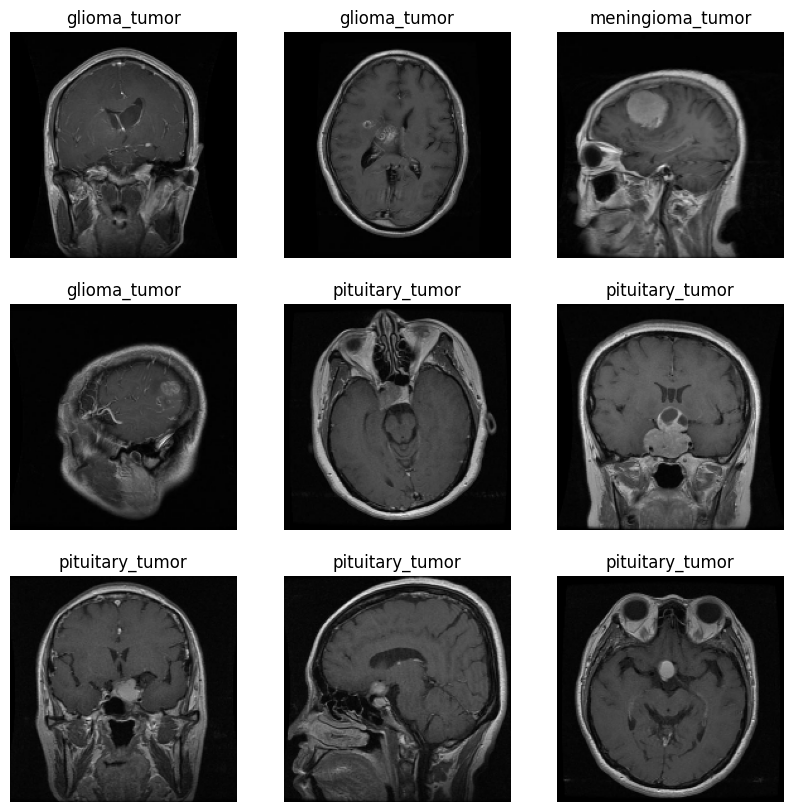

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(300, 180, 180, 3)
(300,)


In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8866225


In [8]:
num_classes = 4

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),  
  tf.keras.layers.Conv2D(32, 3, activation='relu'), 
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [9]:
lr_scheduler=tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-3*10**(epoch/20))


In [10]:
find_lr_history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,callbacks=[lr_scheduler]
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.2658 - loss: 255.0175 - val_accuracy: 0.3328 - val_loss: 5.2232 - learning_rate: 0.0010
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.3066 - loss: 4.8808 - val_accuracy: 0.3780 - val_loss: 1.4031 - learning_rate: 0.0011
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.4915 - loss: 1.2107 - val_accuracy: 0.5784 - val_loss: 1.0352 - learning_rate: 0.0013
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6510 - loss: 0.8821 - val_accuracy: 0.6969 - val_loss: 0.8467 - learning_rate: 0.0014
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.7830 - loss: 0.6227 - val_accuracy: 0.7265 - val_loss: 0.7749 - learning_rate: 0.0016
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8508 - loss: 0.3926 - val_accuracy: 0.7735 - val_loss: 0.6728 - learning_rate: 0.0018
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9273 - loss: 0.2148 - val_accuracy: 0.8275 - val

Text(0.5, 1.0, 'Finding the ideal learning rate')

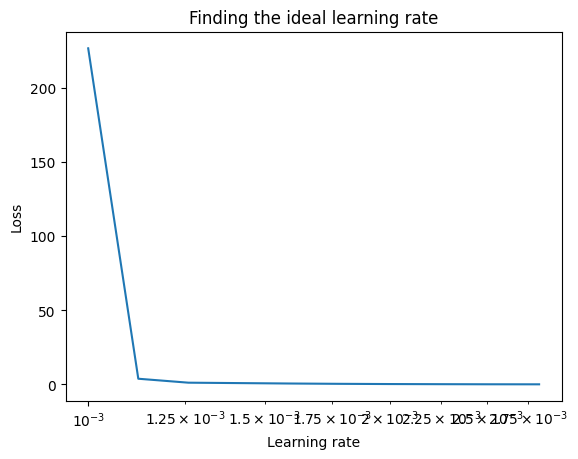

In [11]:
import numpy as np
import matplotlib.pyplot as plt
lrs=1e-3*(10**(tf.range(40)/20))
# Ensure lrs and loss have the same length
lrs = lrs[:len(find_lr_history.history["loss"])]
plt.semilogx(lrs, find_lr_history.history["loss"])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate")

In [12]:
model.evaluate(train_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 587ms/step - accuracy: 0.9952 - loss: 0.0274


[0.024163758382201195, 0.9956446290016174]

In [13]:
def evaluate_model(model, dataset, class_names):
    # Initialize an empty list to store the results
    results = []

    # Initialize empty lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over all batches in the dataset
    for image_batch, labels_batch in dataset:
        # Get predictions for the current batch
        predictions = model.predict(image_batch)

        # Convert labels_batch to a NumPy array
        labels_batch_np = labels_batch.numpy()

        # Store true labels and predicted labels
        true_labels.extend(labels_batch_np)
        predicted_labels.extend(predictions.argmax(axis=1))

        # Compare predictions with true labels and store the results
        for i in range(len(labels_batch_np)):
            comparison = predictions.argmax(axis=1)[i] == labels_batch_np[i]
            results.append(comparison)

    # Convert the results to a DataFrame
    results_df = pd.DataFrame({
        'True Label': true_labels,
        'Predicted Label': predicted_labels,
        'Comparison': results
    })

    # Export the DataFrame to a CSV file
    results_df.to_csv('results.csv', index=False)

    # Calculate and print the total accuracy
    accuracy = np.mean(results)
    print(f'Total Accuracy: {accuracy * 100:.2f}%')

    # Plot the predictions with the labels and accuracy
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
            plt.axis("off")
    plt.show()

    return results_df, accuracy

# Call the function with the model and dataset
#results_df, accuracy = evaluate_model(model, train_ds, class_names)

In [14]:
# model.fit(
#   image_batch,labels_batch,
#   epochs=7
# )

In [15]:
# results_df, accuracy = evaluate_model(model, train_ds, class_names)

In [16]:
# Load the data
data_dir = "C:\\Users\\par\\Desktop\\tensoroflow\\Cancer_cn\\Brain-Tumor-Classification-DataSet-master\\Testing"
img_height = 180
img_width = 180
batch_size = 300
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 374 files belonging to 4 classes.


In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0011730887 0.96519905


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Total Accuracy: 65.78%


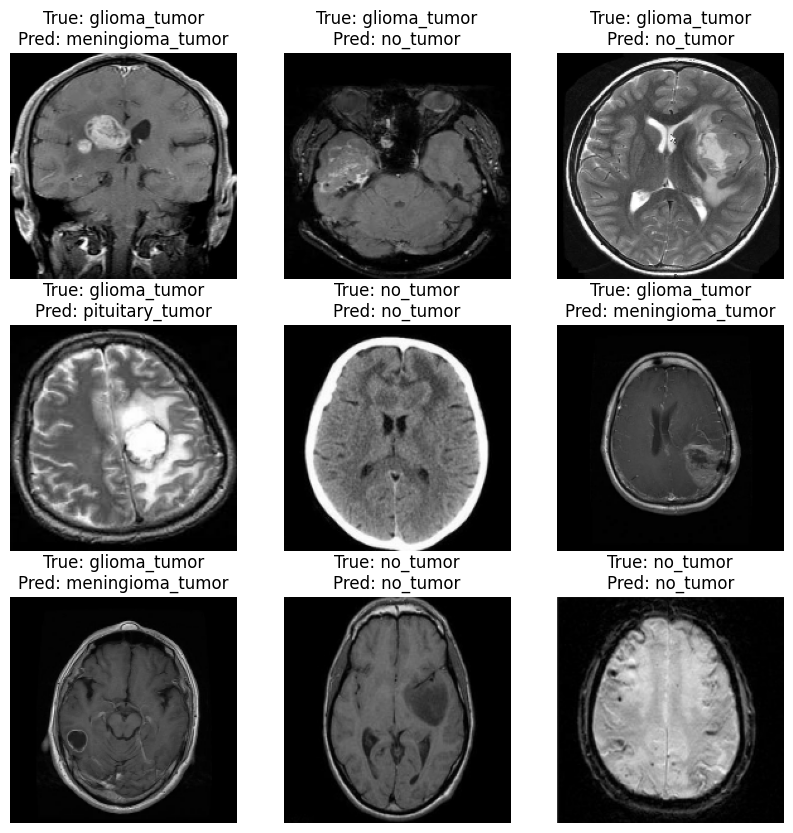

In [18]:
results_df, accuracy = evaluate_model(model, test_ds, class_names)

In [19]:
tf.keras.models.save_model(model, 'model.keras')

In [20]:
model2=tf.keras.models.load_model('model.keras')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Total Accuracy: 65.78%


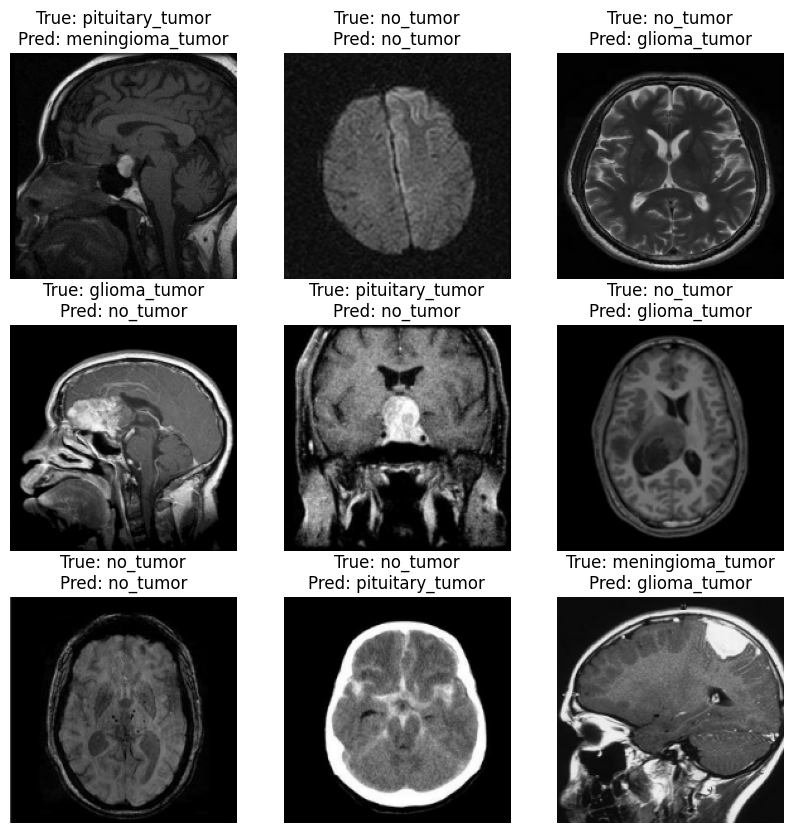

In [21]:
results_df, accuracy = evaluate_model(model2, test_ds, class_names)

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
from timeit import default_timer as timer

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


def random_one_hot_labels(shape):
    n, n_class = shape
    classes = np.random.randint(0, n_class, n)
    tmp_labels = np.zeros((n, n_class))
    tmp_labels[np.arange(n), classes] = 1
    return tmp_labels


data = np.random.random((1000, 32))
labels = random_one_hot_labels((1000, 10))

durations = []
for i in range(1):  # run N times
    start = timer()
    model.fit(data, labels, epochs=500, batch_size=32)
    durations.append(timer() - start)

print(f"tf.version.VERSION = {tf.version.VERSION}")
print(f"tf.keras.__version__ = {tf.keras.__version__}")
devices = device_lib.list_local_devices()  # this may allocate all GPU memory ?!
print(f"devices = {[x.name for x in devices]}")
print(f"model.fit durations: {durations}")

Epoch 1/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0928 - loss: 2.3253 
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1024 - loss: 2.2983
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1351 - loss: 2.2750
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1540 - loss: 2.2646 
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1481 - loss: 2.2574 
Epoch 6/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1879 - loss: 2.2510
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2100 - loss: 2.2255 
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1834 - loss: 2.2259 
Epoch 9/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2103 - loss: 2.2063 
Epoch 10/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2340 - loss: 2.1848 
Epoch 11/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2286 - loss: 2.1774
Epoch 12/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - ac

KeyboardInterrupt: 

In [ ]:
import tensorflow.compat.v1 as tf
from tensorflow.keras import layers
import numpy as np
from timeit import default_timer as timer
# uncomment to force CPU
#tf.config.experimental.set_visible_devices([], "DML")

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

model = tf.keras.models.Sequential([
layers.Flatten(input_shape=(28, 28, 1)),
layers.Dense(4096,activation='relu'),
layers.Dense(4096,activation='relu'),
layers.Dense(10, activation='softmax')
])
model.summary()
durations = []
model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'],)
start = timer()
model.fit(np.expand_dims(x_train,3), y_train, epochs=8, batch_size=1024)
durations.append(timer() - start)
print(durations)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4096)           │     3,215,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,037,642 (76.44 MB)

 Trainable params: 20,037,642 (76.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 566ms/step - accuracy: 0.7784 - loss: 0.7257
Epoch 2/2
59/59 ━━━━━━━━━━━━━━━━━━━━ 35s 591ms/step - accuracy: 0.9749 - loss: 0.0843
